## Model Analysis

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
from itertools import permutations
from itertools import combinations
from pyEDM import *
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
import time
import os
from copy import deepcopy
import math
import random
from sklearn.metrics import root_mean_squared_error
from scipy.stats import ttest_ind
import pickle
import ast
import json



from IPython.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))

import warnings
warnings.filterwarnings("ignore", 
    message="A worker stopped while some jobs were given to the executor.",
    module="joblib.externals.loky.process_executor")

In [36]:
data_path = "Data/carter_data_w_gaps.csv"
model_path = "1000_sample_HAB_cor_driver_carter_models.csv"


In [37]:
def str_to_list(s):
    s = s.replace('nan', 'null')  # Replace 'nan' with 'null' for JSON compatibility
    lst = json.loads(s)  # Convert string to list
    lst = [np.nan if x is None else x for x in lst]  # Replace None with np.nan
    return lst

def process_parameters(path):

    parameters = pd.read_csv(path) 
    parameters['pred'] = parameters['pred'].apply(str_to_list)
    parameters['columns'] = parameters['columns'].apply(ast.literal_eval)
    parameters.sort_values(by='rho',ascending=False)
    return parameters

def clean_data(data_path):
    paper_data = pd.read_csv(data_path)
    paper_data = paper_data.set_index('time')
    paper_data['Time'] = paper_data.index.astype(int)
    paper_data['Avg_Chloro'] #= paper_data['Avg_Chloro'].apply(np.log1p) #LOG AMPUTATION
    #IMPUTE HAB DATA
    #Build basic linear regression model as sanity check
    # Custom impute missing values with the average of the value in front and behind of it 
    class ForwardBackwardImputer(BaseEstimator, TransformerMixin):
        def __init__(self):
            pass

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            X_filled_forward = X.fillna(method='ffill').fillna(method='bfill')
            X_filled_backward = X.fillna(method='bfill').fillna(method='ffill')

            return (X_filled_forward + X_filled_backward) / 2


    Imputer = ForwardBackwardImputer()
    paper_data = paper_data.apply(pd.to_numeric, errors='coerce')
    Imputer.fit(paper_data)
    paper_data = Imputer.transform(paper_data)#COMMENT OUT IF DONT WANT MEAN MPUTE
    return paper_data

In [38]:

data = clean_data(data_path)
parameters = process_parameters(model_path)
target = 'Avg_Chloro'#'Lingulodinium_polyedra'#'


/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_13866/1510975273.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_filled_forward = X.fillna(method='ffill').fillna(method='bfill')
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_13866/1510975273.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_filled_backward = X.fillna(method='bfill').fillna(method='ffill')


FileNotFoundError: [Errno 2] No such file or directory: '1000_sample_HAB_cor_driver_carter_models.csv'

In the 95th percentile there are 2388 models


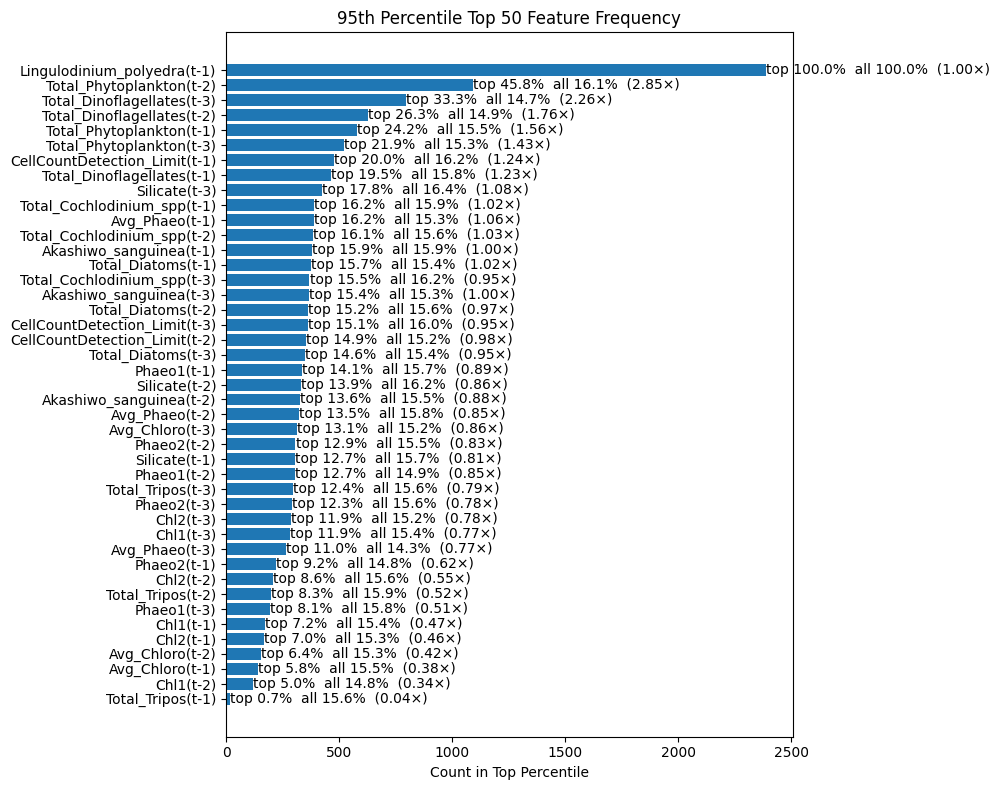

In [9]:
import matplotlib.pyplot as plt

def visualize_common_lags(parameters, percentile, top_n=15):
    # ensure sorted
    parameters = parameters.sort_values(by='rho', ascending=False).reset_index(drop=True)
    N_all = parameters.shape[0]
    N_top = int(N_all * (1 - percentile/100))
    print(f'In the {percentile}th percentile there are {N_top} models')

    # overall counts
    param_cnts_all = {}
    for cols in parameters['columns']:
        for lag in cols:
            param_cnts_all[lag] = param_cnts_all.get(lag, 0) + 1

    # top-percentile counts
    param_cnts_top = {}
    for i in range(N_top):
        for lag in parameters['columns'].iloc[i]:
            param_cnts_top[lag] = param_cnts_top.get(lag, 0) + 1

    # get top_n lags by top count
    sorted_items = sorted(param_cnts_top.items(), key=lambda x: x[1], reverse=True)[:top_n]
    if not sorted_items:
        print("No parameters to display.")
        return

    lags, counts_top = zip(*sorted_items)
    # compute percentages and enrichment
    pct_top = [ (c/N_top)*100 for c in counts_top ]
    pct_all = [ (param_cnts_all[lag]/N_all)*100 for lag in lags ]
    enrichment = [ (counts_top[i]/N_top) / (param_cnts_all[lags[i]]/N_all)
                   for i in range(len(lags)) ]

    # plot
    plt.figure(figsize=(10, 8))
    bars = plt.barh(lags, counts_top)
    plt.xlabel("Count in Top Percentile")
    plt.title(f"{percentile}th Percentile Top {top_n} Feature Frequency")
    plt.gca().invert_yaxis()

    # annotate each bar with pct_top / pct_all and enrichment
    for bar, pt, pa, enr in zip(bars, pct_top, pct_all, enrichment):
        x = bar.get_width()
        y = bar.get_y() + bar.get_height()/2
        plt.text(x + 0.5, y,
                 f"top {pt:.1f}%  all {pa:.1f}%  ({enr:.2f}×)",
                 va='center')

    plt.tight_layout()
    plt.show()

# usage
visualize_common_lags(parameters, 95, top_n=50)


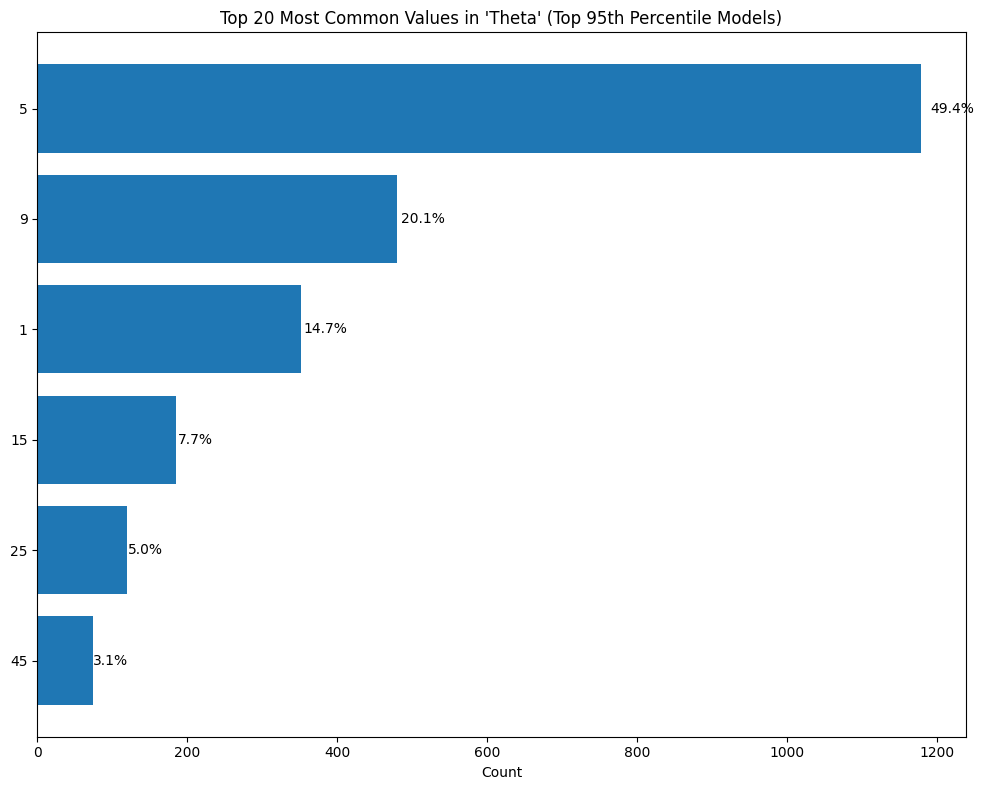

In [10]:
import matplotlib.pyplot as plt

def visualize_common_theta(parameters, percentile, top_n=15):
    """
    For the top `percentile` of models (by 'rho'), count the most
    frequent values in column 'E' and plot the top_n with percentages.
    """
    # Sort by rho descending and take the top percentile
    df_sorted = parameters.sort_values(by='rho', ascending=False)
    num_models = int(len(df_sorted) * (1 - percentile / 100))
    if num_models <= 0:
        print(f"No models in the top {percentile} percentile.")
        return
    top_df = df_sorted.iloc[:num_models]

    # Count the E-values
    counts = top_df['theta'].value_counts().head(top_n)
    if counts.empty:
        print("No values to display in column 'E'.")
        return

    values = counts.index.astype(str)
    freqs = counts.values

    # Plot horizontal bar chart
    plt.figure(figsize=(10, 8))
    bars = plt.barh(values, freqs)
    plt.xlabel("Count")
    plt.title(f"Top {top_n} Most Common Values in 'Theta' (Top {percentile}th Percentile Models)")
    plt.gca().invert_yaxis()

    # Annotate with percentages
    for bar, freq in zip(bars, freqs):
        pct = freq / num_models * 100
        plt.text(bar.get_width() + max(freq*0.01, 0.5),
                 bar.get_y() + bar.get_height()/2,
                 f'{pct:.1f}%',
                 va='center')
    plt.tight_layout()
    plt.show()


# Usage:
visualize_common_theta(parameters, percentile=95, top_n=20)


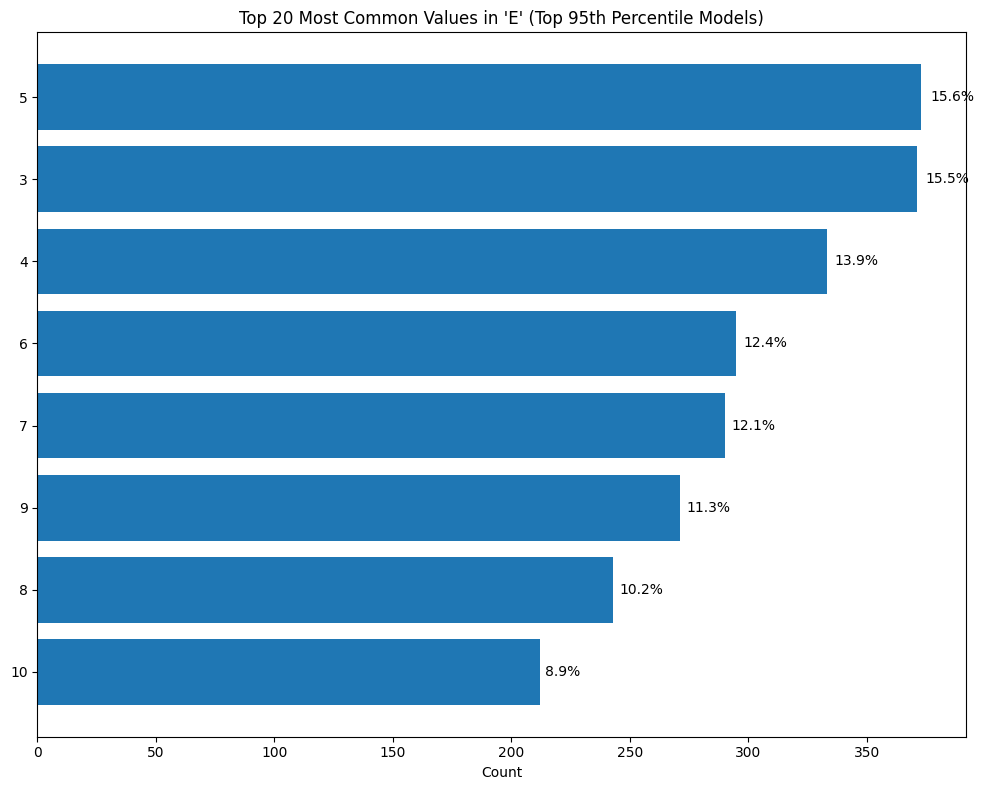

In [11]:
import matplotlib.pyplot as plt

def visualize_common_E(parameters, percentile, top_n=15):
    """
    For the top `percentile` of models (by 'rho'), count the most
    frequent values in column 'E' and plot the top_n with percentages.
    """
    # Sort by rho descending and take the top percentile
    df_sorted = parameters.sort_values(by='rho', ascending=False)
    num_models = int(len(df_sorted) * (1 - percentile / 100))
    if num_models <= 0:
        print(f"No models in the top {percentile} percentile.")
        return
    top_df = df_sorted.iloc[:num_models]

    # Count the E-values
    counts = top_df['E'].value_counts().head(top_n)
    if counts.empty:
        print("No values to display in column 'E'.")
        return

    values = counts.index.astype(str)
    freqs = counts.values

    # Plot horizontal bar chart
    plt.figure(figsize=(10, 8))
    bars = plt.barh(values, freqs)
    plt.xlabel("Count")
    plt.title(f"Top {top_n} Most Common Values in 'E' (Top {percentile}th Percentile Models)")
    plt.gca().invert_yaxis()

    # Annotate with percentages
    for bar, freq in zip(bars, freqs):
        pct = freq / num_models * 100
        plt.text(bar.get_width() + max(freq*0.01, 0.5),
                 bar.get_y() + bar.get_height()/2,
                 f'{pct:.1f}%',
                 va='center')
    plt.tight_layout()
    plt.show()


# Usage:
visualize_common_E(parameters, percentile=95, top_n=20)


In [12]:
#Make prediction based on if p% of n models predict bloom
def eval_ensemble(obs_blooms, pred_blooms):
    Accuracy = 1 - (obs_blooms ^ pred_blooms).mean()
    True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
    False_pos = ((~obs_blooms) & pred_blooms).sum() / (~obs_blooms).sum()
    True_neg = ((~obs_blooms) & (~pred_blooms)).sum() / (~obs_blooms).sum()
    False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()
    
    return [Accuracy, True_pos, False_pos, True_neg, False_neg]
    

'''
Inputs:
p -> val less than 1 which represents proportions of models which must predict bloom (aka the sensitivity)
n -> from n top models
samp -> num from n*samp top models
outputs -> array of trues and falses of blooms
'''
def ensemble_binary_bloom(parameters_df,n=100,p=0.1,samp=1,bloom_thresh=np.percentile(data[target],95)):
    #parameters_df = parameters_df.sort_values(by='rmse',ascending=True)
    parameters_df = parameters_df.iloc[0:n*samp:samp]#.sample(n)#
    sum = np.zeros(np.array(parameters_df['pred'].iloc[0][1:-1]).size)
    for i in range(n):
        curr = np.array(parameters_df['pred'].iloc[i][1:-1]) > bloom_thresh#np.percentile(parameters_df['pred'].iloc[i][1:-1],95)#bloom_thresh
        sum = sum + curr
    return sum > (n*p), sum



Bloom threshold is 11733.399999999963
311
In the eval set there is 69 blooms


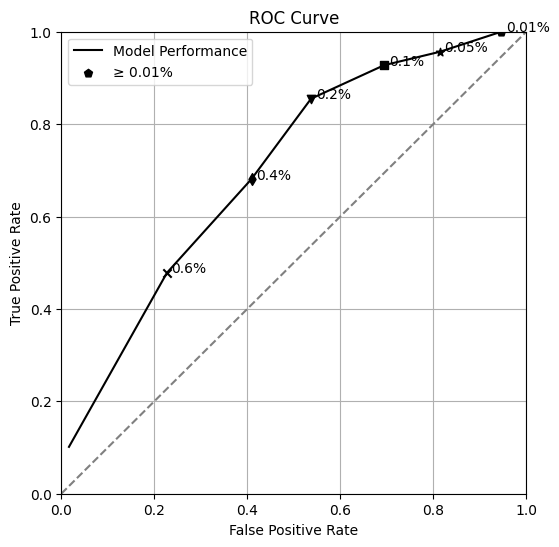

In [34]:
#plot ROC for various sensitivities
bloom_thresh = np.percentile(data[target].iloc[:513],95)
print(f'Bloom threshold is {bloom_thresh}')
parameters = parameters.sort_values(by='rmse',ascending=True)
results, _ = ensemble_binary_bloom(parameters,samp=1,p=0.1,bloom_thresh=bloom_thresh,n=3)
observations = data[target].iloc[-1*len(results):] > bloom_thresh
print(len(observations))
print(f'In the eval set there is {sum(observations)} blooms')
p_list = [0.01,0.05,0.1,0.2,0.4,0.6,0.9]
samp = 20#40
num_models = 2000#750
TP_list = []
FP_list = []
for p in p_list:
    results, _ = ensemble_binary_bloom(parameters,samp=samp,p=p,bloom_thresh=bloom_thresh,n=num_models)
    eval = eval_ensemble(observations, results)
    TP_list.append(eval[1])
    FP_list.append(eval[2])

markers = ['p', '*', 's', 'v', 'd', 'x']  
plt.figure(figsize=(6,6))
plt.plot(FP_list, TP_list, linestyle='-', color='black', marker='None', label="Model Performance")

for i, (fp, tp, p, marker) in enumerate(zip(FP_list, TP_list, p_list, markers)):
    plt.scatter(fp, tp, marker=marker, color='black', label=f"≥ {p}%" if i == 0 else "")
    plt.text(fp + 0.01, tp, f"{p}%", fontsize=10)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.title("ROC Curve")
plt.show()

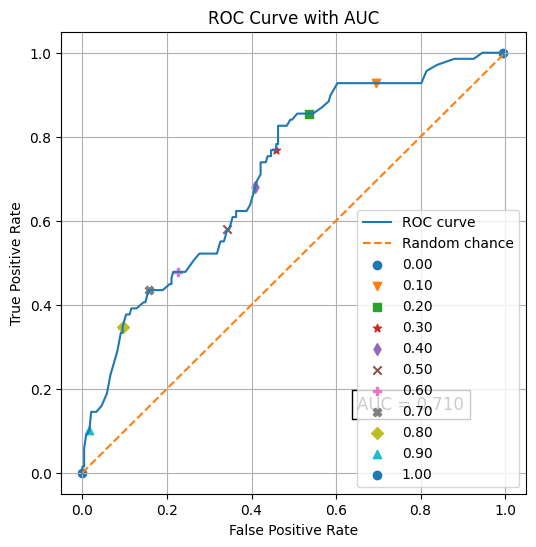

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# 1) Define a fine-grained set of p thresholds
p_list = np.arange(0.00, 1.01, 0.01)

TP_list = []
FP_list = []

for p in p_list:
    results, _ = ensemble_binary_bloom(parameters, samp=samp, p=p, bloom_thresh=bloom_thresh, n=num_models)
    eval = eval_ensemble(observations, results)
    TP_list.append(eval[1])
    FP_list.append(eval[2])

# 2) Compute the AUC
roc_auc = auc(FP_list, TP_list)

# 3) Plot ROC and annotate AUC
plt.figure(figsize=(6,6))
plt.plot(FP_list, TP_list, label="ROC curve")
plt.plot([0,1], [0,1], linestyle="--", label="Random chance")

# Draw each threshold point and label first one only in legend
markers = ['o','v','s','*','d','x','P','X','D','^']  # enough unique markers
for i, (fp, tp, p) in enumerate(zip(FP_list[::10], TP_list[::10], p_list[::10])):  
    plt.scatter(fp, tp, marker=markers[i % len(markers)], label=f"{p:.2f}")

# Annotate with AUC
plt.text(0.65, 0.15, f"AUC = {roc_auc:.3f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [33]:
import numpy as np
from sklearn.metrics import auc

# 1) Precompute your bloom threshold and true labels once
bloom_thresh = np.percentile(data[target].iloc[:513], 95)
observations = data[target].iloc[-len(data[target]) + 513:] > bloom_thresh

# 2) Define the grid of hyperparameters you want to try
samp_values      = [1,2,5, 10, 20, 30, 40, 50,75,100,125,150,175,200,250,300,350,400,500,600,700,800,1000]
model_count_vals = [100, 250,400, 500,750,900,1000]# 1500,2000,3000,4000,5000

# 3) Set up variables to track the best run
best_auc    = 0.0
best_params = {'samp': None, 'num_models': None}

# 4) The thresholds at which to evaluate your ensemble
thresholds = np.arange(0.0, 1.01, 0.01)

# 5) Grid search
for samp in samp_values:
    for num_models in model_count_vals:
        if samp*num_models > parameters.shape[0]:
            print(f'Skipping samp={samp} and num_models={num_models} bc too large')
            continue
        tprs = []
        fprs = []
        for p in thresholds:
            preds, _   = ensemble_binary_bloom(parameters,
                                               samp=samp,
                                               p=p,
                                               bloom_thresh=bloom_thresh,
                                               n=num_models)
            metrics = eval_ensemble(observations, preds)
            # metrics = [Accuracy, TPR, FPR, TNR, FNR]
            TPR = metrics[1]
            FPR = metrics[2]
            tprs.append(TPR)
            fprs.append(FPR)

        current_auc = auc(fprs, tprs)
        print(f"samp={samp:>2}, num_models={num_models:>4} → AUC = {current_auc:.4f}")

        if current_auc > best_auc:
            best_auc = current_auc
            best_params = {'samp': samp, 'num_models': num_models}

# 6) Report your winner
print("\n>>> Best AUC {:.4f} with samp={} and num_models={}"
      .format(best_auc, best_params['samp'], best_params['num_models']))


samp= 1, num_models= 100 → AUC = 0.5976
samp= 1, num_models= 250 → AUC = 0.6394
samp= 1, num_models= 400 → AUC = 0.6587
samp= 1, num_models= 500 → AUC = 0.6638
samp= 1, num_models= 750 → AUC = 0.6687
samp= 1, num_models= 900 → AUC = 0.6671
samp= 1, num_models=1000 → AUC = 0.6672
samp= 2, num_models= 100 → AUC = 0.5950
samp= 2, num_models= 250 → AUC = 0.6624
samp= 2, num_models= 400 → AUC = 0.6659
samp= 2, num_models= 500 → AUC = 0.6658
samp= 2, num_models= 750 → AUC = 0.6665
samp= 2, num_models= 900 → AUC = 0.6706
samp= 2, num_models=1000 → AUC = 0.6703
samp= 5, num_models= 100 → AUC = 0.6271
samp= 5, num_models= 250 → AUC = 0.6562
samp= 5, num_models= 400 → AUC = 0.6744
samp= 5, num_models= 500 → AUC = 0.6746
samp= 5, num_models= 750 → AUC = 0.6807
samp= 5, num_models= 900 → AUC = 0.6887
samp= 5, num_models=1000 → AUC = 0.6869
samp=10, num_models= 100 → AUC = 0.6481
samp=10, num_models= 250 → AUC = 0.6713
samp=10, num_models= 400 → AUC = 0.6789
samp=10, num_models= 500 → AUC = 0.6818


In [16]:
parameters.sort_values(by='rho',ascending=False)

,Unnamed: 0,target,columns,E,theta,rho,rmse,pred
14812,14812,Lingulodinium_polyedra,"[Avg_Chloro(t-3), CellCountDetection_Limit(t-1...",5,15,0.452603,6.601909e+05,"[nan, 732.0530619288539, 2895.734415266481, 55..."
2104,2104,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Total_Cochlodi...",3,9,0.424563,1.380554e+06,"[nan, 1708.2045401373607, 142.15206247945207, ..."
3699,3699,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Silicate(t-2),...",3,15,0.420112,1.108281e+06,"[nan, 1704.6744083358303, -56.264749860488905,..."
3405,3405,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Total_Diatoms(...",3,15,0.416923,1.016861e+07,"[nan, 954.5740473607618, 2913.983875850172, -6..."
4095,4095,Lingulodinium_polyedra,"[Akashiwo_sanguinea(t-1), CellCountDetection_L...",3,25,0.416559,6.619425e+06,"[nan, 904.0337399199803, 1598.5815540583208, 8..."
...,...,...,...,...,...,...,...,...
10579,10579,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Total_Cochlodi...",4,25,-0.410007,7.543374e+06,"[nan, 772.8026197807853, 1576.3671858377202, 5..."
4284,4284,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Total_Cochlodi...",3,25,-0.411557,7.562781e+06,"[nan, 821.9274309767625, 1582.9789121130816, 5..."
4747,4747,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Total_Cochlodi...",3,25,-0.413474,1.451262e+08,"[nan, 1326.9542177802882, 173.98537972146045, ..."
11573,11573,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Total_Cochlodi...",4,45,-0.426600,1.323909e+07,"[nan, 265.5121370909869, 1873.0452730833786, 8..."


In [17]:
data

,Unnamed: 0,Temp,Chl1,Chl2,Avg_Chloro,Phaeo1,Phaeo2,Avg_Phaeo,Nitrate,Phosphate,...,BOT_SAL_PSU,SURF_TEMP_C,BOT_TEMP_C,WSPD,SURF_DENS_kgm3,BOT_DENS_kgm3,AVG_TEMP_C,AVG_SAL_PSU,AVG_DENS_kgm3,Time
time,,,,,,,,,,,,,,,,,,,,,
0,0.0,19.8,1.81,1.83,1.82,0.59,0.61,0.60,0.43,0.24,...,33.62,20.3,15.90,4.691667,1023.638094,1024.620655,18.100,33.6950,1024.129374,0.0
1,1.0,17.3,2.68,2.73,2.71,1.24,1.12,1.18,0.83,0.37,...,33.62,17.8,16.90,2.787500,1024.186379,1024.391719,17.350,33.6400,1024.289049,1.0
2,2.0,21.7,0.99,1.00,0.99,0.55,0.54,0.55,0.45,0.24,...,33.58,22.2,18.30,3.412500,1023.100557,1024.026040,20.250,33.6600,1023.563298,2.0
3,3.0,20.2,1.21,1.24,1.23,0.49,0.48,0.48,0.34,0.17,...,33.62,19.8,19.40,3.495833,1023.701088,1023.780535,9.900,33.6500,1023.740812,3.0
4,4.0,22.4,2.37,2.44,2.41,0.41,0.36,0.39,0.29,0.12,...,33.69,22.5,22.50,2.604167,1023.009067,1023.000725,11.250,33.7100,1023.004896,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,819.0,15.6,2.87,2.84,2.86,0.44,0.47,0.46,0.87,0.20,...,33.38,15.4,15.00,2.525694,1024.534776,1024.636187,15.200,33.3850,1024.585481,819.0
820,820.0,14.4,1.50,1.50,1.50,0.56,0.65,0.60,0.87,0.20,...,33.34,14.6,14.50,1.893750,1024.684291,1024.712299,14.550,33.3500,1024.698295,820.0
821,821.0,13.8,3.51,3.25,3.38,0.88,1.13,1.00,0.87,0.20,...,33.36,13.5,13.40,5.088889,1024.926719,1024.953741,13.450,33.3700,1024.940230,821.0


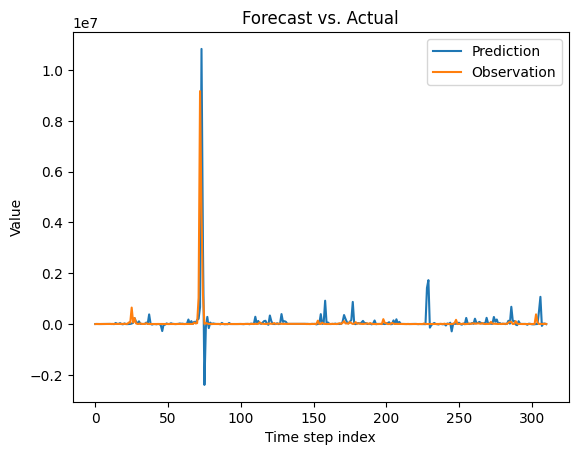

In [18]:

def plot_forecast_vs_observation(pred_vals, obs_vals,
                                 xlabel='Time step index',
                                 ylabel='Value',
                                 title='Forecast vs. Actual'):
    """
    Plots two sequences of floats: predictions and observations.

    Parameters
    ----------
    pred_vals : array-like of float
        The predicted values.
    obs_vals : array-like of float
        The true observed values.
    xlabel : str, optional
        Label for the x-axis (default: 'Time step index').
    ylabel : str, optional
        Label for the y-axis (default: 'Value').
    title : str, optional
        Plot title (default: 'Forecast vs. Actual').
    """
    # Convert inputs to 1D float arrays
    pred = np.asarray(pred_vals, dtype=float).ravel()
    obs  = np.asarray(obs_vals, dtype=float).ravel()

    # Plot
    plt.figure()
    plt.plot(pred, label='Prediction')
    plt.plot(obs,  label='Observation')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()


pred_f_one = parameters.sort_values(by='rho',ascending=False)['pred'].iloc[0][1:-1]
observations_vals = data[target].iloc[-1*len(results):]
plot_forecast_vs_observation(pred_f_one,observations_vals)

In [19]:
parameters.sort_values(by='rho',ascending=False)

,Unnamed: 0,target,columns,E,theta,rho,rmse,pred
14812,14812,Lingulodinium_polyedra,"[Avg_Chloro(t-3), CellCountDetection_Limit(t-1...",5,15,0.452603,6.601909e+05,"[nan, 732.0530619288539, 2895.734415266481, 55..."
2104,2104,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Total_Cochlodi...",3,9,0.424563,1.380554e+06,"[nan, 1708.2045401373607, 142.15206247945207, ..."
3699,3699,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Silicate(t-2),...",3,15,0.420112,1.108281e+06,"[nan, 1704.6744083358303, -56.264749860488905,..."
3405,3405,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Total_Diatoms(...",3,15,0.416923,1.016861e+07,"[nan, 954.5740473607618, 2913.983875850172, -6..."
4095,4095,Lingulodinium_polyedra,"[Akashiwo_sanguinea(t-1), CellCountDetection_L...",3,25,0.416559,6.619425e+06,"[nan, 904.0337399199803, 1598.5815540583208, 8..."
...,...,...,...,...,...,...,...,...
10579,10579,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Total_Cochlodi...",4,25,-0.410007,7.543374e+06,"[nan, 772.8026197807853, 1576.3671858377202, 5..."
4284,4284,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Total_Cochlodi...",3,25,-0.411557,7.562781e+06,"[nan, 821.9274309767625, 1582.9789121130816, 5..."
4747,4747,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Total_Cochlodi...",3,25,-0.413474,1.451262e+08,"[nan, 1326.9542177802882, 173.98537972146045, ..."
11573,11573,Lingulodinium_polyedra,"[CellCountDetection_Limit(t-1), Total_Cochlodi...",4,45,-0.426600,1.323909e+07,"[nan, 265.5121370909869, 1873.0452730833786, 8..."


In [20]:
len(data[target][513:])

311